# Load covidtracking data and make some plots

- v3: MH lots of refactoring, added lowess bootstrap; went to v3 to avoid conflicts with Hannah midwest cahnges
- v2: MH refactor code from the doubling time plots


----------
- 4/25 todo
  - [ ] when I get time, consolidate all the calculation code so we're passing objects around not these crazy param structs - which are fine but should only be created once and not copied around.  
  - [ ] change filenames so they sort correctly?
- 4/24 todo
  - [ ] fix date offset
  - [ ] get MN to work - probably requires fixing up how the ````doubling[st]```` stuff is done
  - [X] title for testing plot
  

- 4/12 todo
  - [X] make the doubling time plot for deaths
  
- 4/6 todo
  - [X] set arrow location automatically (xmax)
  
- 4/5 todo
  - [X] hannah refactored code, I adapted with recent updates
  - [X] run code tonight
  - [X] fix death inset not being annotated
  

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytoolsMH as ptMH
import pandas as pd
import seaborn as sns
import os,sys
import scipy.io
import scipy.stats as ss
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import json
import datetime, dateutil.parser
from argparse import Namespace

sns.set_style('whitegrid')

from src import covid_casesMH as cvd

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

mpl.rc('pdf', fonttype=42) # embed fonts on pdf output 

r_ = np.r_

## covidtracking.com data

In [2]:
r = requests.get('https://covidtracking.com/api/states/daily')
data = r.json()
ctDf = pd.DataFrame(data)

# save current data
datestr = datetime.datetime.now().strftime('%y%m%d')
ctDf.to_hdf('./ct-data/covidtracking-data-%s.h5'%datestr, key='ct', complevel=9, complib='zlib')

In [3]:
paramsC = pd.DataFrame(index={'DC','MD','VA','NY'}, columns=['fullname'])
paramsC.loc[:,'fullname'] = pd.Series({ 'DC': 'District of Columbia', 'MD': 'Maryland', 'VA': 'Virginia'})
paramsC.loc[:,'labYOff'] = pd.Series({ 'DC': -15, 'MD': +10, 'VA': -10, 'NY':-15})
paramsC.loc[:,'labXOff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': +5, 'NY': 0})
paramsC.loc[:,'lw'] = pd.Series({ 'DC': 2, 'MD': 2, 'VA': 2, 'NY': 0.8})
#params.loc[:,'xoff'] = pd.Series({ 'DC': -9, 'MD': -6, 'VA': -6, 'NY': -0.3})
paramsC.loc[:,'xoff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': 0, 'NY': -1})
paramsC.loc[:,'color'] = pd.Series({ 'NY': 0.4, 'DC': '#1f77b4', 'MD': '#ff7f0e', 'VA': '#2ca02c'})

display(paramsC)

,fullname,labYOff,labXOff,lw,xoff,color
DC,District of Columbia,-15,0,2.0,0,#1f77b4
NY,NaN,-15,0,0.8,-1,0.4
VA,Virginia,-10,5,2.0,0,#2ca02c
MD,Maryland,10,0,2.0,0,#ff7f0e


In [4]:
#Data: http://covidtracking.com  updated Apr 04 2020, 20:00 EDTGraphic: Hannah Goldbach, Mark Histed  @hannah_goldbach @histedlab
tDStr = datetime.date.today().strftime('%b %-d 2020')
tCredStr = 'Updated %s, 20:00 EDT\n  data: http://covidtracking.com\nGraphic: Hannah Goldbach, Mark Histed\n  @hannah_goldbach @histedlab' % tDStr
print(tCredStr)

Updated May 10 2020, 20:00 EDT
  data: http://covidtracking.com
Graphic: Hannah Goldbach, Mark Histed
  @hannah_goldbach @histedlab


Latest data for DC: 2020-05-10 00:00:00
Latest data for MD: 2020-05-10 00:00:00
Latest data for VA: 2020-05-10 00:00:00
Latest data for NY: 2020-05-10 00:00:00


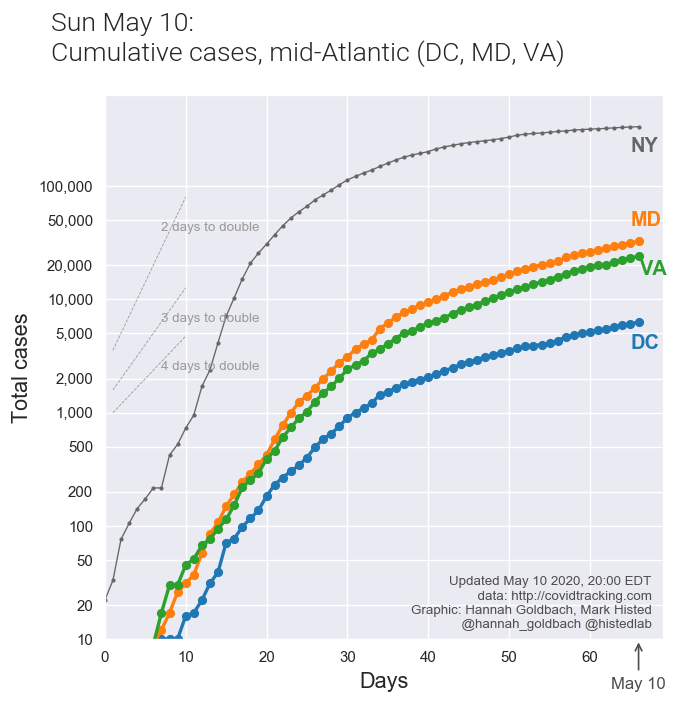

In [5]:
doInset = False

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=r_[1,1]*6, dpi=120)

# big plot - states
df = ctDf.copy()
for st in ['DC', 'MD', 'VA', 'NY']:
    df, paramsC = cvd.plot_state(df, st, paramsC, ax, False)

xmax = np.max(paramsC.loc['DC','plot_data']['xs'])
xlim = r_[0,xmax+3]
    
# big plot fixup
cvd.fixups(ax)
#ADJUST AXIS LIMS TO FIT 
ax.set_xlim(xlim)  
ax.set_ylim([10, ax.get_ylim()[1]])
ax.set_ylabel('Total cases')

cvd.plot_guide_lines(ax)

# inset
if doInset:
    ylim = r_[450, 3200]*2.3 #ADJUST YLIM TO FIT 
    axins = cvd.inset(ctDf, paramsC, ax, ylim, is_inset=True)

#case doubling lines 
xs = r_[1,10] #ADJUST COORDS AS CASES CLIMB
dtL = [2,3,4]
if doInset:
    cvd.case_anno_inset_double(xs, axins, paramsC) #might have to adjust in scropt 

#add arrow
tStr = datetime.date.today().strftime('%B %-d')
ax.annotate(tStr, xy=(xmax,10), xycoords='data', xytext=(0,-30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='0.3'),
            color='0.3', ha='center')

## credit string
ax.annotate(tCredStr, xy=(0.98,0.02), xycoords='axes fraction', ha='right', fontsize=8, color='0.3')
fig.suptitle(f"{datetime.date.today().strftime('%a %B %-d')}: \n"
             'Cumulative cases, mid-Atlantic (DC, MD, VA)',
             fontsize=16, fontname='Roboto', fontweight='light', 
             x=0.05, y=0.92, ha='left', va='bottom')

fig.savefig('./fig-output/ct-%s.png'%datestr, dpi=300, bbox_inches='tight', pad_inches=0.5)
            #bbox_inches=r_[0,0,10,15])#, 

### Same plot for deaths

In [6]:
paramsD = paramsC.copy()

Latest data for DC: 2020-05-10 00:00:00
Latest data for MD: 2020-05-10 00:00:00
Latest data for VA: 2020-05-10 00:00:00
Latest data for NY: 2020-05-10 00:00:00


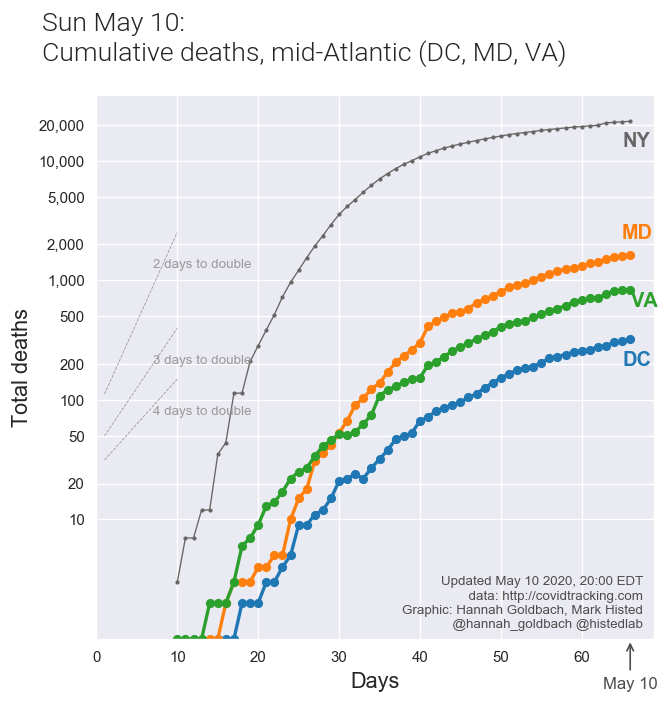

In [7]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=r_[1,1]*6, dpi=120)

df = ctDf.copy()
for st in ['DC', 'MD', 'VA', 'NY']:
    df, paramsD = cvd.plot_state(df, st, paramsD, ax, False, is_cases=False)

# big plot fixup
cvd.fixups(ax)
#ADJUST AXIS LIMS TO FIT 
ax.set_xlim(xlim)  
ax.set_ylim([1, ax.get_ylim()[1]])
ax.set_ylabel('Total deaths')
cvd.plot_guide_lines(ax, yoffset_mult=10**-1.5)

# inset
ylim = r_[9, 50]*1.3 #ADJUST YLIM TO FIT  - get aspect ratio right
#cvd.inset(df, paramsD, ax, ylim, is_inset=True, is_cases=False)


#Death doubling annotation
#cvd.case_anno_inset_double(xs, axins, paramsD) #might have to adjust in scropt 


#add arrow
tStr = datetime.date.today().strftime('%B %-d')
ax.annotate(tStr, xy=(xmax, 1), xycoords='data', xytext=(0,-30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='0.3'), 
            color='0.3', ha='center')

ax.annotate(tCredStr, xy=(0.98,0.02), xycoords='axes fraction', ha='right', fontsize=8, color='0.3')
fig.suptitle(f"{datetime.date.today().strftime('%a %B %-d')}: \n"
             'Cumulative deaths, mid-Atlantic (DC, MD, VA)',
             fontsize=16, fontname='Roboto', fontweight='light', 
             x=0.05, y=0.92, ha='left', va='bottom')


fig.savefig('./fig-output/dt-%s.png'%datestr, dpi=300, bbox_inches='tight', pad_inches=0.5)
            #bbox_inches=r_[0,0,10,15])#, 

In [8]:
for state in ['DC']:
    desIx = ctDf.state == state
    stDf = ctDf.loc[desIx,:].copy()
    stDf.set_index('date', inplace=True)

    posV = stDf.loc[:,'positive'][::-1]

# Positive test rates in MD, DC, VA
multipanel plot

''

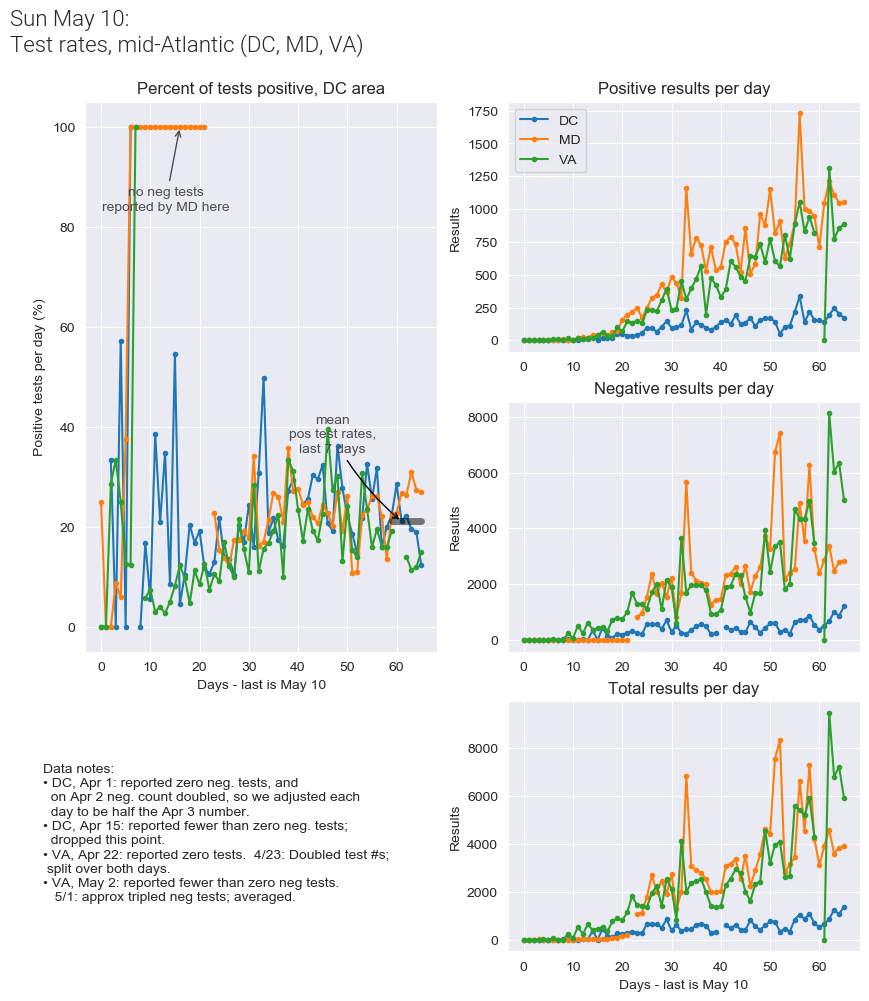

In [22]:
plott = cvd.PlotTesting(ctDf)

fig = plott.fig_multipanel_test(doSave=True)
;


## Positive test rate plots: smoothed, with bootstrap CI


Automatic pdb calling has been turned OFF


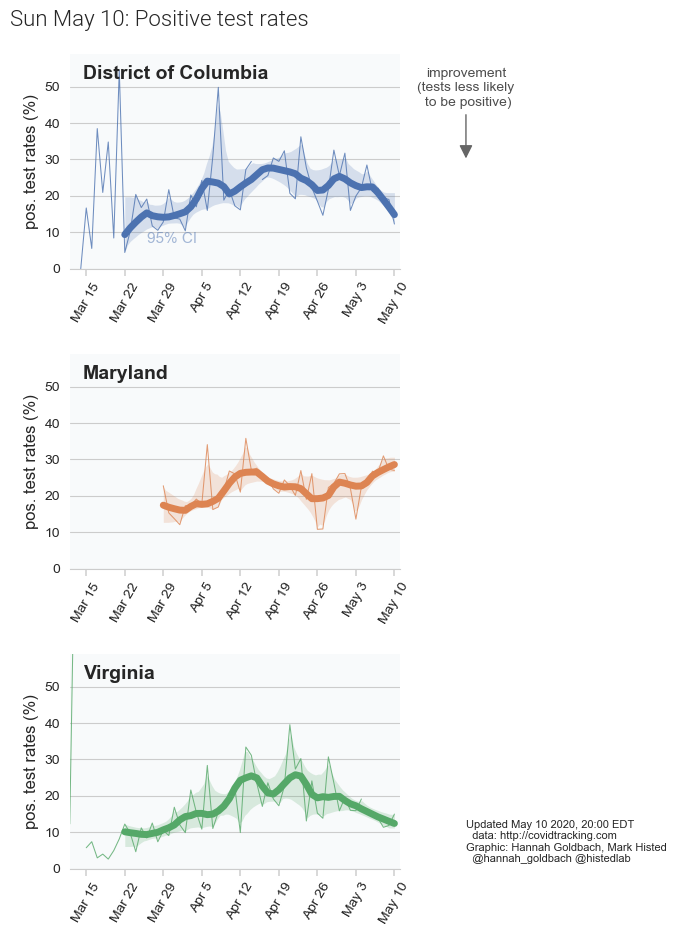

In [23]:
%pdb off
plott = cvd.PlotTesting(ctDf)

fig = plott.fig_pos_test_rate(title_str='Positive test rates', 
                              nbootreps=1000, doSave=True)

## MH figure of doubling rates
- refactored into covid_cases.py MH 200412

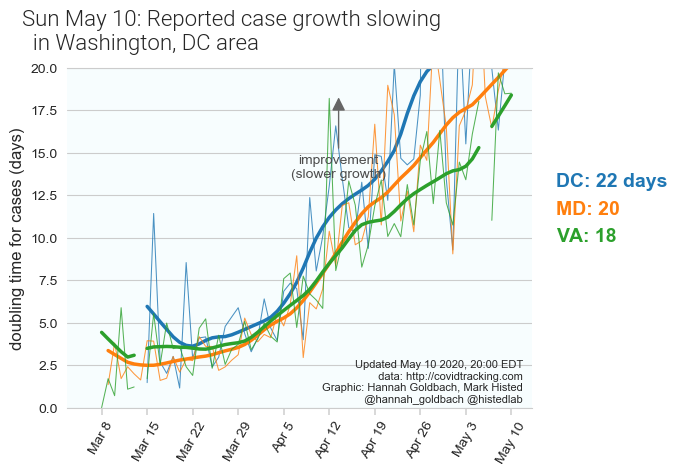

In [13]:
plotd = cvd.PlotDoubling(params=paramsC, smoothSpan=14)

plotd.plot_doubling(title_str='Reported case growth slowing \n  in Washington, DC area', ylim=(0,20))




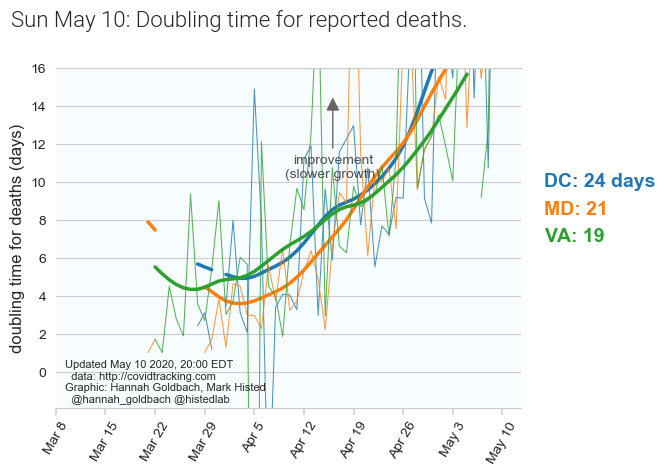

In [14]:
plotd = cvd.PlotDoubling(params=paramsD, smoothSpan=21)

plotd.plot_doubling(title_str='Doubling time for reported deaths.',
                    cred_left=True, ylim=[-1.9,16], yname='deaths')



## case increment plot, with LOWESS fit

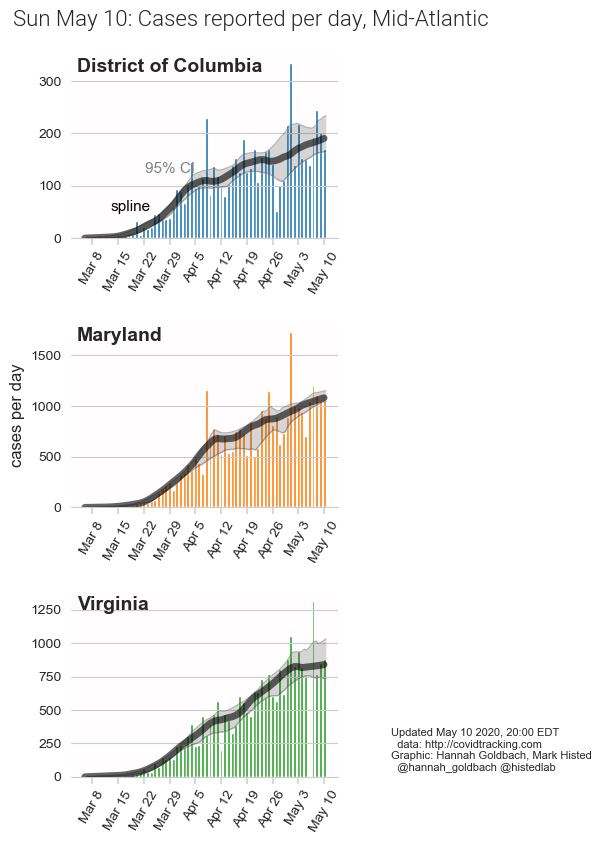

In [15]:
nbootreps=1000
plotd = cvd.PlotDoubling(params=paramsC, smoothSpan=13)

plotd.fig_increment(doSave=True, yname='cases', nbootreps=nbootreps, smoothSpan=13, title_str='Cases reported per day, Mid-Atlantic')

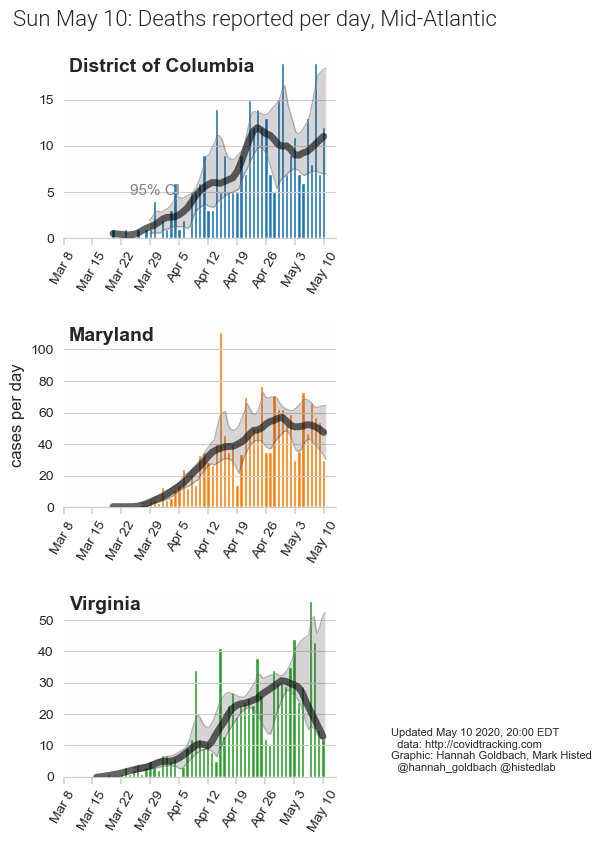

In [16]:
plotd = cvd.PlotDoubling(params=paramsD, smoothSpan=13)

plotd.fig_increment(doSave=True, yname='deaths', nbootreps=nbootreps, smoothSpan=13, title_str='Deaths reported per day, Mid-Atlantic')

## cases per day, by state, with lowess fit

This cell for testing, with a single axis panel

just WI, IL

Latest data for WI: 2020-05-10 00:00:00
Latest data for IL: 2020-05-10 00:00:00


,fullname,labYOff,labXOff,lw,xoff,color,plot_data
DC,District of Columbia,-15.0,0.0,2.0,0.0,#1f77b4,"{'xs': [66, 65, 64, 63, 62, 61, 60, 59, 58, 57..."
NY,NaN,-15.0,0.0,0.8,-1.0,0.4,"{'xs': [66, 65, 64, 63, 62, 61, 60, 59, 58, 57..."
VA,Virginia,-10.0,5.0,2.0,0.0,#2ca02c,"{'xs': [66, 65, 64, 63, 62, 61, 60, 59, 58, 57..."
MD,Maryland,10.0,0.0,2.0,0.0,#ff7f0e,"{'xs': [66, 65, 64, 63, 62, 61, 60, 59, 58, 57..."
WI,Wisconsin,NaN,NaN,NaN,NaN,"[0.8901960784313725, 0.4666666666666667, 0.760...","{'xs': [67, 66, 65, 64, 63, 62, 61, 60, 59, 58..."
IL,Illinois,NaN,NaN,NaN,NaN,"[0.7372549019607844, 0.7411764705882353, 0.133...","{'xs': [67, 66, 65, 64, 63, 62, 61, 60, 59, 58..."


''

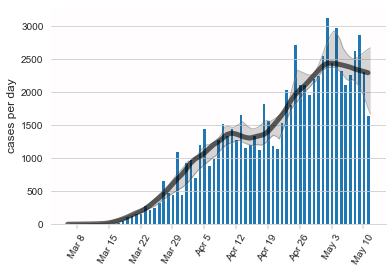

In [17]:
stateL = ['WI','IL']
nbootreps=10

paramsD.loc['WI',:] = pd.Series({'color':r_[sns.color_palette()[6]], 'fullname': 'Wisconsin'})
paramsD.loc['IL',:] = pd.Series({'color':r_[sns.color_palette()[8]], 'fullname': 'Illinois'})
#display(paramsD)
for state in stateL:
    xs, ys, dtV = cvd.df_to_plotdata(df, state, is_cases=True)
    paramsD.loc[state,'plot_data'] = [{'xs':xs, 'ys':ys, 'dtV': dtV}]
display(paramsD)    

plotd = cvd.PlotDoubling(params=paramsD, stateList=stateL, smoothSpan=13)


plotd.plot_increment('IL', doFit=True, nbootreps=nbootreps, color=sns.color_palette()[0])
;
#plotd.fig_increment(doSave=True, yname='deaths', title_str='Deaths reported per day, Mid-Atlantic')

try to get MN working too

stateL = ['WI','IL','MN']
nbootreps=10

paramsD.loc['WI',:] = pd.Series({'color':r_[sns.color_palette()[6]], 'fullname': 'Wisconsin'})
paramsD.loc['IL',:] = pd.Series({'color':r_[sns.color_palette()[8]], 'fullname': 'Illinois'})
paramsD.loc['IL',:] = pd.Series({'color':r_[sns.color_palette()[8]], 'fullname': 'Minnesota'})
#display(paramsD)
for state in stateL:
    xs, ys, dtV = cvd.df_to_plotdata(df, state, is_cases=True)
    paramsD.loc[state,'plot_data'] = [{'xs':xs, 'ys':ys, 'dtV': dtV}]
display(paramsD)    

plotd = cvd.PlotDoubling(params=paramsD, stateList=stateL, smoothSpan=13)


#plotd.plot_increment('IL', doFit=True, nbootreps=nbootreps, color=sns.color_palette()[0])
plotd.plot_increment('MN', doFit=True, nbootreps=nbootreps, color=sns.color_palette()[0])
;
#plotd.fig_increment(doSave=True, yname='deaths', title_str='Deaths reported per day, Mid-Atlantic')

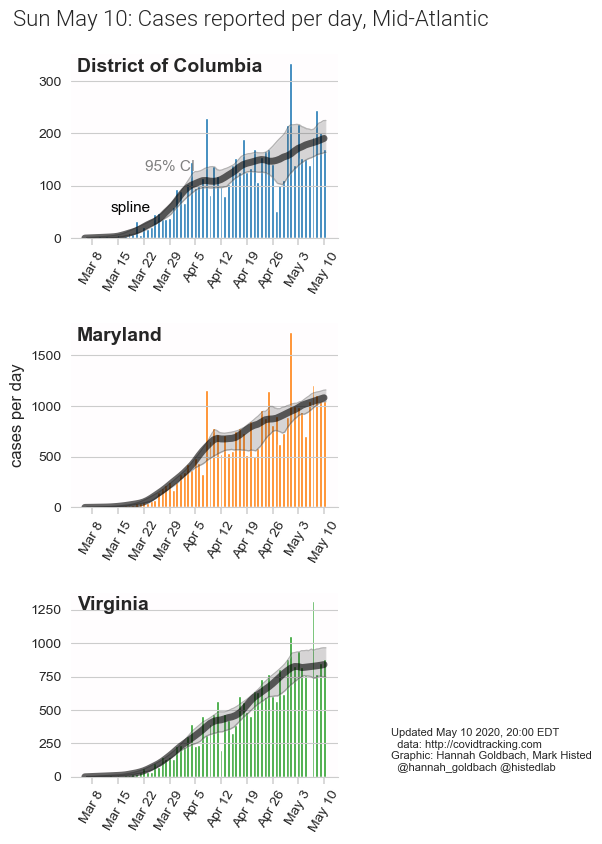

In [18]:
plotd = cvd.PlotDoubling(params=paramsC, smoothSpan=13)
nbootreps=1000

plotd.fig_increment(doSave=True, yname='cases', nbootreps=nbootreps, smoothSpan=13, title_str='Cases reported per day, Mid-Atlantic')

## Bigger midwest figure, case numbers and pos test numbers
- refactored into a function

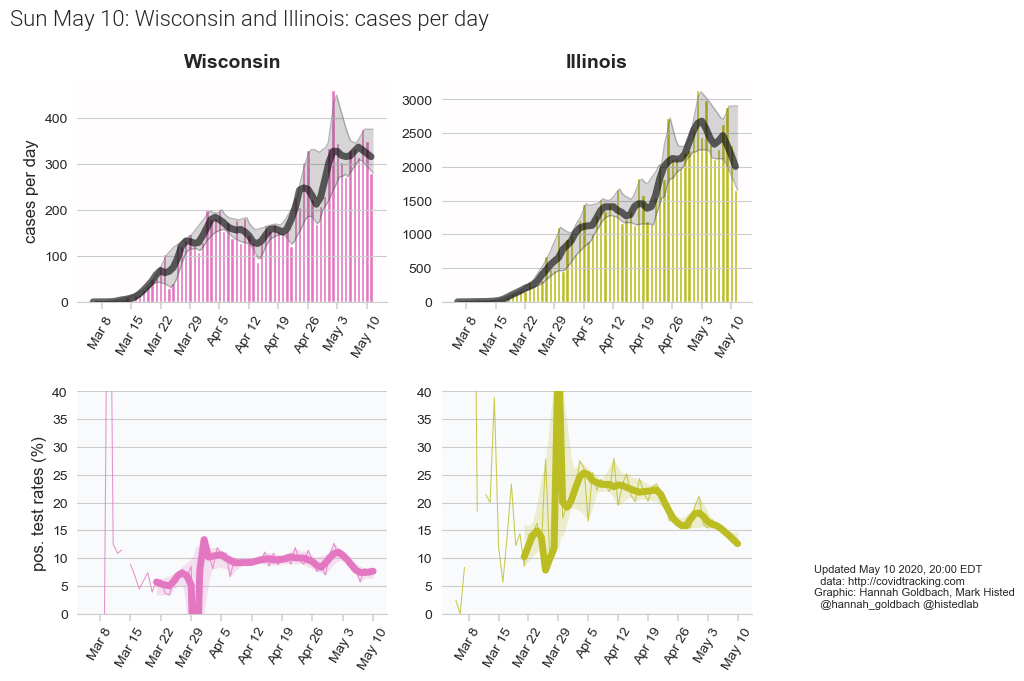

In [19]:
cvd.fig_midwest(paramsD, stateL, ctDf, nbootreps=1000)